# **ETPoF** Homework 3
Annemarie Linnenbank & Tommie Verouden

*22 March 2024*

## Particle Tracking (25 points)
### 1) **Calibration** (3 pts)

Assume that the background noise is the same throughout the image, and the vertical line has an angle of 0° (which, on 
closer inspection, is the case).

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import etpof
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

res_avg, res_std, lineheight = etpof.calibrate_cameras('PTV', roi=[200, 250, 30, 670], 
                                           calib_dist=500, threshold=60,
                                           file_prefix='Calibration_', 
                                           verbose=True, plot=False,
                                           precision=8)

# TODO: Check average heigh offset compared beteen the two cameras

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.19it/s]

==> Calibration_a.png:
The average resolution is 4.88918152 mm/px,
with a standard deviation of 0.00183618 mm/px (0.0375559 %).
==> Calibration_b.png:
The average resolution is 4.88946346 mm/px,
with a standard deviation of 0.00167924 mm/px (0.034344 %).
Offset: -0.04942322 mm


### 2) **Particle detection** (3 pts)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 156.17it/s]


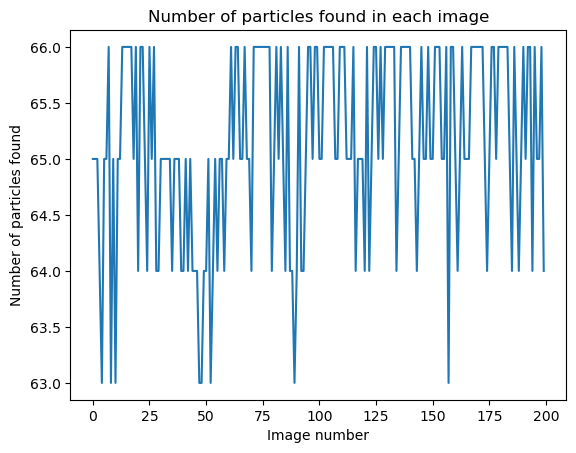

Found between 63 and 66 particles in each image, with a median of 65.0.


In [2]:
coordsA, intensitiesA, coords_errA, intensities_errA, particles_found\
    = etpof.analyze_camera('PTV', 'a', res_avg/1000, min_cnt_area=1, 
                     min_intensity=200, neighbor_dist=2.5, box_margin=3, 
                     max_iter=5, verbose=True, plot=True)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 156.22it/s]


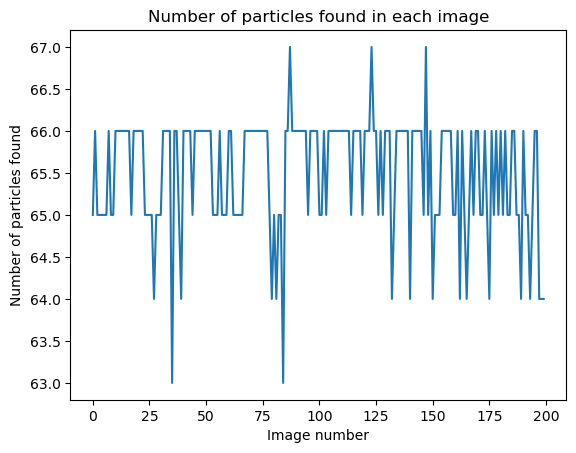

Found between 63 and 67 particles in each image, with a median of 66.0.


In [3]:
coordsB, intensitiesB, coords_errB, intensities_errB, particles_found\
    = etpof.analyze_camera('PTV', 'b', res_avg/1000, min_cnt_area=1, 
                     min_intensity=200, neighbor_dist=2.5, box_margin=3, 
                     max_iter=5, verbose=True, plot=True)

#### Below we show the detected particles, their tracks colored in time for clarity ####

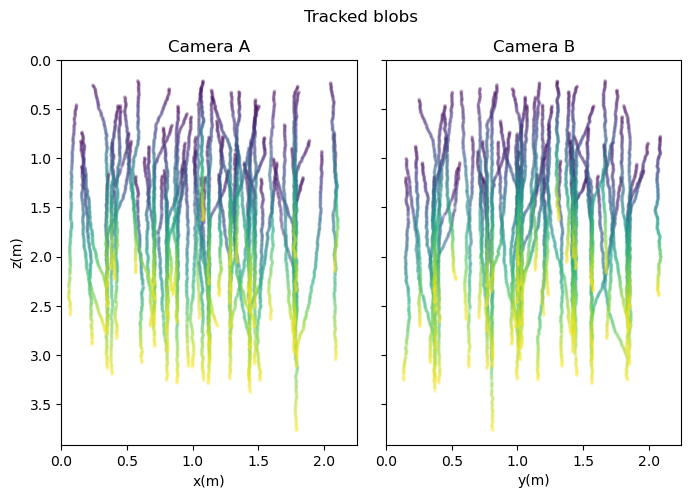

In [4]:
nN = 200
xA = np.zeros((len(coordsA), 2))
zA = np.zeros((len(coordsA), 2))
yB = np.zeros((len(coordsB), 2))
zB = np.zeros((len(coordsB), 2))

xA[:,0] = coordsA[:,1]
xA[:,1] = coordsA[:,2]
zA[:,0] = coordsA[:,0]
zA[:,1] = coordsA[:,2]

yB[:,0] = coordsB[:,1]
yB[:,1] = coordsB[:,2]
zB[:,0] = coordsB[:,0]
zB[:,1] = coordsB[:,2]

# Plot data
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
plt.subplots_adjust(wspace=0.1)
fig.suptitle('Tracked blobs')
axs[0].scatter(xA[:, 0], zA[:,0], alpha=0.2, s=3, c=xA[:,1])#, cmap='hsv')
axs[0].set_ylim([800*(res_avg[0]/1000), 0])
axs[0].set_xlim([0, 460*(res_avg[0]/1000)])
axs[0].set_xlabel('x(m)')
axs[0].set_ylabel('z(m)')
axs[0].set_title('Camera A')

axs[1].scatter(yB[:, 0], zB[:,0], alpha=0.2, s=3, c=zB[:,1])#, cmap='hsv')
axs[1].set_ylim([800*(res_avg[0]/1000), 0])
axs[1].set_xlim([0, 460*(res_avg[0]/1000)])
axs[1].set_xlabel('y(m)')
axs[1].set_title('Camera B')
axs[1].set_yticklabels([])
plt.show()


### a3) 3D matching (6 points)
The 3D matching is done by taking the coordinates on the i-th image and taking the z-coordinate (vertical) of the particles on this image. We then find the closest matching z-coordinate on the other image. We do not yet track where the particle was on the previous frame, so our matching will not be perfect by any means. This is because the z-coordinate on the second frame which is closest to the first coordinate might not be the correct one and this gives a very different y-coordinate than expected. This can only be fixed by tracking where the particle was in the previous frame and making sure the new coordinate is not too far from the previous coordinate. This is done in the next exercises.
\
\
We also initially had the idea to first track our particles in 2D and then match the tracks on both cameras by their z-coordinate, however we believed this not to be the idea of the exercise, while we later learnt this would have been an acceptable approach. We believe a better plan would have been to make a good 2D tracker (which we did do) and then match the tracks found on camera A and B (which we did not have time for anymore).

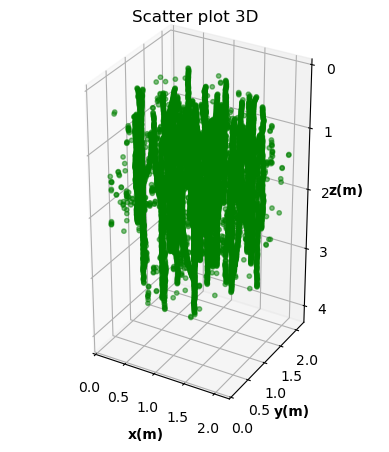

In [19]:
# matching particle tracks (without taking into account previous particle position)
x3D = np.zeros(0)
y3D = np.zeros(0)
z3DA = np.zeros(0)
z3DB = np.zeros(0)

for i in range(len(xA[:,0])):
    #take points on ith frame
    maskA = (xA[:,1] == i)
    maskB = (yB[:,1] == i)
    
    x = xA[:,0][maskA]
    y = yB[:,0][maskB]
    za = zA[:,0][maskA]
    zb = zB[:,0][maskB]
    
    for j in range(1, len(x)):
        #take z and x coordiate to match
        z0A = za[j]
        x0 = x[j]
        
        #find smallest distance between in list of zb and z0
        zlist = abs(zb - z0A)
        index = np.argmin(zlist) #finds index of smallest value, aka smallest distance
        
        
        
        y0 = y[index]
        z0B = zb[index]
        
        #save to arrays
        x3D = np.append(x3D, x0)
        y3D = np.append(y3D, y0)
        z3DA = np.append(z3DA, z0A)
        z3DB = np.append(z3DB, z0B)

# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
ax1.scatter(x3D, y3D, z3DA, color = "green", alpha = 0.5, s = 10)
#ax.scatter3D(x3D, y3D, z3DB, color = "blue", alpha = 0.5, s = 10)
plt.title("Scatter plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450*(res_avg[0]/1000))
ax1.set_ylim(0, 450*(res_avg[0]/1000))
ax1.set_zlim(860*(res_avg[0]/1000), 0)
# show plot
plt.show()

### a4) Tracking (6 points)
We start our tracking in the middle at a point where all particles have been detected, then work our way forward and backwards, before connecting the found tracks. We can see below that this does not use all points and tracks. So we then take all unused points and track lines through those and repeat until we are left with no points. The functions we wrote first uses nearest neighbour for the first few points, before switching to the predictor method using the velocity of the particle. We tried see if smoothing the already found tracks would help in using the predictor method, but this did not seem to be the case.

In [8]:
from PTV_functions import PTV_3D_Final
from PTV_functions import PTV_3D_Final_forw
from PTV_functions import PTV_3D_Final_back
from PTV_functions import removal
from PTV_functions import leftovers

In [9]:
x3d, y3d, z3d = PTV_3D_Final_forw(xA, zA, yB, zB, middle_frame=1, R=6*(res_avg[0]/1000),Rz=5*(res_avg[0]/1000), Rv=3*(res_avg[0]/1000), n_vel=4)
x3d, y3d, z3d = removal(x3d, y3d, z3d, Rmax=0.05) #remove outliers

xA_left1, zA_left1, yB_left1, zB_left1 = leftovers(x3d, y3d, z3d, xA, zA, yB, zB)
mid=1
end=200
x3d_1, y3d_1, z3d_1 = PTV_3D_Final_back(xA_left1, zA_left1, yB_left1, zB_left1, middle_frame=mid, R=6*(res_avg[0]/1000), Rz=5*(res_avg[0]/1000), Rv=3*(res_avg[0]/1000), n_vel=200, nN=end)
x3d_1, y3d_1, z3d_1 = removal(x3d_1, y3d_1, z3d_1, Rmax=0.05) #remove outliers

maxp = np.max(x3d[:,2])#max_particles
x3d_1[:,2] = x3d_1[:,2] + maxp +1
y3d_1[:,2] = y3d_1[:,2] + maxp +1
z3d_1[:,2] = z3d_1[:,2] + maxp +1

x3d = np.vstack((x3d, x3d_1))
y3d = np.vstack((y3d, y3d_1))
z3d = np.vstack((z3d, z3d_1))

#repeat
xA_left1, zA_left1, yB_left1, zB_left1 = leftovers(x3d, y3d, z3d, xA, zA, yB, zB)
mid=17
end=200
x3d_1, y3d_1, z3d_1 = PTV_3D_Final_forw(xA_left1, zA_left1, yB_left1, zB_left1, middle_frame=mid, R=6*(res_avg[0]/1000), Rz=5*(res_avg[0]/1000), Rv=3*(res_avg[0]/1000), n_vel=200, nN=end)
x3d_1, y3d_1, z3d_1 = removal(x3d_1, y3d_1, z3d_1, Rmax=0.05) #remove outliers

maxp = np.max(x3d[:,2])#max_particles
x3d_1[:,2] = x3d_1[:,2] + maxp +1
y3d_1[:,2] = y3d_1[:,2] + maxp +1
z3d_1[:,2] = z3d_1[:,2] + maxp +1

x3d = np.vstack((x3d, x3d_1))
y3d = np.vstack((y3d, y3d_1))
z3d = np.vstack((z3d, z3d_1))

path_xA = x3d
path_yB = y3d
path_zA = z3d

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.02it/s]


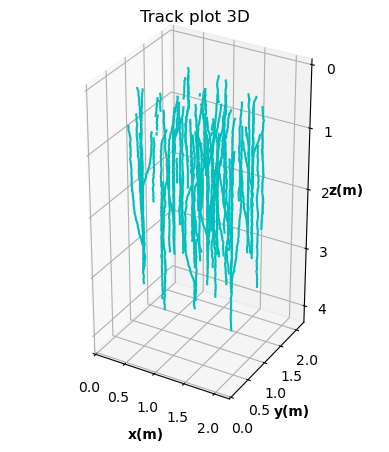

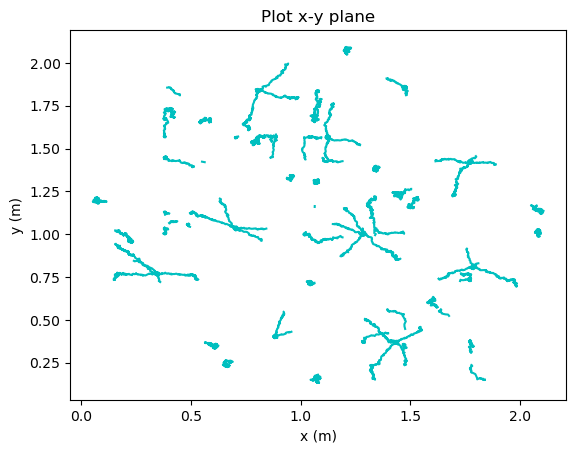

In [10]:
# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
for i in range(0, int(np.max(y3d[:,2]))+1):
    mask = (y3d[:,2]==i)
    ax1.plot(x3d[:,0][mask], y3d[:,0][mask], z3d[:,0][mask],c='c')
plt.title("Track plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450*(res_avg[0]/1000))
ax1.set_ylim(0, 450*(res_avg[0]/1000))
ax1.set_zlim(860*(res_avg[0]/1000), 0)
# show plot

plt.figure()
plt.title('Plot x-y plane')
for i in range(0, int(np.max(y3d[:,2]))+1):
    mask = (y3d[:,2]==i)
    plt.plot(x3d[:,0][mask], y3d[:,0][mask], c='c')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


#### Our attempt at 2D matching and then matching the tracks, we did not get further than making a 2D tracker, we did not have time to match tracks to make them 3D ####

In [ ]:
from PTV_functions import PTV_2DMiddle

#find 2D paths
xA_m, zA_m = PTV_2DMiddle(xA, zA, middle_frame=65, n_velocity=2, Rmax_v=5, Rmax_n=3, nN=200)
yB_m, zB_m = PTV_2DMiddle(yB, zB, middle_frame= 136, n_velocity=4, Rmax_v=6, Rmax_n=3, nN=200)
# Plot data
plt.figure()
plt.scatter(xA[:, 0], zA[:,0], alpha=0.3, c='gray', s=10)
for i in range(0, int(np.max(xA_m[:,2]))+1):
    mask = (xA_m[:,2]==i)
    plt.plot(xA_m[:,0][mask], zA_m[:,0][mask], c = f'C{i%6}')
plt.ylim(860, 0)
plt.xlim(0, 460)
plt.title('Camera A')
plt.show()

# Plot data
plt.figure()
plt.scatter(yB[:, 0], zB[:,0], alpha=0.3, c='gray', s=10)
for i in range(0, int(np.max(yB_m[:,2]))+1):
    mask = (yB_m[:,2]==i)
    plt.plot(yB_m[:,0][mask], zB_m[:,0][mask], c = f'C{i%6}')
plt.ylim(860, 0)
plt.xlim(0, 460)
plt.title('Camera B')
plt.show()

### a5) Velocity

To calculate the velocities of the particles, we take the track of a particle (which is sorted by time) and calculate the velocities in the horizontal and vertical directions. In the PDFs below we can see that the velocity is the x- and y-directions have approximately the same probability density function, while the velocity in the z-direction is generally higher and positive (which means downwards in this case). The PDFs also seem to be Gaussian in shape. However, the paths we have found are quite jagged, so it may be beneficial to smooth our paths. We do this below too, we visually inspected the smoothed paths to make sure that the new paths are not over smoothed. We see that the PDFs remain pretty much the same as before.

In [11]:
fps = 25 #Hz
dt = 1/fps
p = 1 #between particles
vx = np.zeros(0)
vy = np.zeros(0)
vz = np.zeros(0)
for i in tqdm(range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    #find track of ith particle
    mask = (path_xA[:,2]==i)
    x = path_xA[:,0:2][mask]
    y = path_yB[:,0:2][mask]
    z = path_zA[:,0:2][mask]
    
    #calculate velocities
    for j in range(len(x)-p): #for each frame
        distance_x = (x[j+1,0]-x[j, 0])
        distance_y = (y[j+1,0]-y[j, 0])
        distance_z = (z[j+1,0]-z[j, 0])
        time = dt*(x[j+1,1]-x[j,1])
        
        vx = np.append(vx, distance_x/time)
        vy = np.append(vy, distance_y/time)
        vz = np.append(vz, distance_z/time)

100%|███████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 285.87it/s]


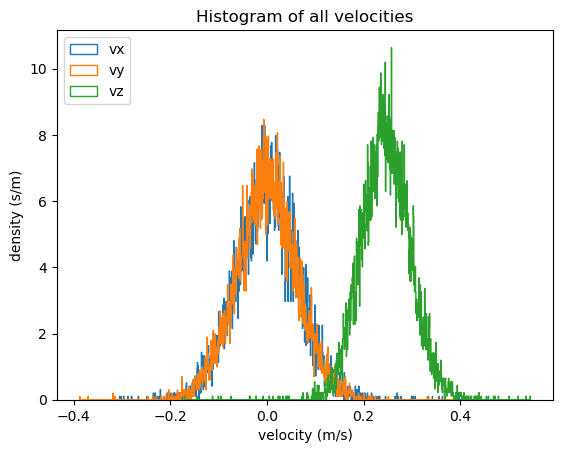

In [12]:
plt.figure()
plt.hist(vx, bins=1000, density=True, histtype='step', label='vx')
plt.hist(vy, bins=1000, density=True, histtype='step', label='vy')
plt.hist(vz, bins=1000, density=True, histtype='step', label='vz')
plt.title('Histogram of all velocities')
plt.xlabel('velocity (m/s)')
plt.ylabel('density (s/m)')
plt.legend()
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 270.25it/s]


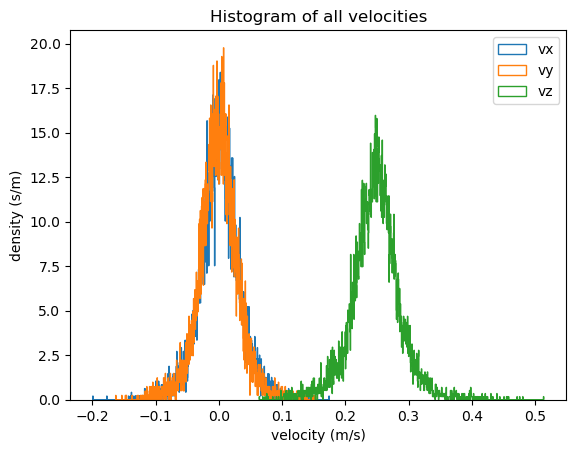

In [18]:
fps = 25 #Hz
dt = 1/fps
p = 1 #between particles
vx = np.zeros(0)
vy = np.zeros(0)
vz = np.zeros(0)

from scipy import signal

for i in tqdm(range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    #find track of ith particle
    mask = (path_xA[:,2]==i)
    x = path_xA[:,0:2][mask]
    y = path_yB[:,0:2][mask]
    z = path_zA[:,0:2][mask]
    if len(x)>=10:
        xs = signal.savgol_filter(x[:,0], 10, 3)
        ys = signal.savgol_filter(y[:,0], 10, 3)
        zs = signal.savgol_filter(z[:,0], 10, 3)

        #calculate velocities
        for j in range(len(x)-p): #for each frame
            distance_x = (xs[j+1]-xs[j])
            distance_y = (ys[j+1]-ys[j])
            distance_z = (zs[j+1]-zs[j])
            time = dt*(x[j+1,1]-x[j,1])

            vx = np.append(vx, distance_x/time)
            vy = np.append(vy, distance_y/time)
            vz = np.append(vz, distance_z/time)
        
plt.figure()
plt.hist(vx, bins=1000, density=True, histtype='step', label='vx')
plt.hist(vy, bins=1000, density=True, histtype='step', label='vy')
plt.hist(vz, bins=1000, density=True, histtype='step', label='vz')
plt.title('Histogram of all velocities')
plt.xlabel('velocity (m/s)')
plt.ylabel('density (s/m)')
plt.legend()
plt.show()

# angle not over whole range, equation wrong?
### a6) Alignment (3 points)
To find the alignments we first find the particles which are within 0.4 meters of another particle, we then calculate the angle between the two particles using the equation $\theta=\arccos{\frac{\sqrt{(x_i - x_{i+1})^2 + (y_i - y_{i+1})^2}}{(z_i - z_{i+1})}}$.
\
\
We see in the histogram below, that for the first 100 frames there seem to be three angles which are slightly prefered over others, the middle one being at $\pi/2$ and with two peaks on either side. The last 100 frames shows that there is a clear preference for the particles to be at an angle of $\pi/2$.

In [14]:
angle_1to99 = np.zeros(0)
angle_100to200 = np.zeros(0)

import math

for i in (range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    for j in range(1, 100+1): #for each frame
        mask = (path_xA[:,2] == i) & (path_xA[:,1] == j) #for particle i, on frame j
        x = path_xA[:,0][mask]
        y = path_yB[:,0][mask]
        z = path_zA[:,0][mask]
        
        if len(x) != 0:
        
            mask2 = (path_xA[:,2] != i) & (path_xA[:,1] == j) #for all other particles, on frame j
            x_other = path_xA[:,0][mask2]
            y_other = path_yB[:,0][mask2]
            z_other = path_zA[:,0][mask2]

            distances = np.sqrt(abs(x-x_other)**2 + abs(y-y_other)**2 + abs(z-z_other)**2)
            mask3 = (distances <= 0.4) #should be 0.4 meter, but didn't include calibration yet
            x_other = x_other[mask3]
            y_other = y_other[mask3]
            z_other = z_other[mask3]
            
            #print(x_other)

            #calculate angle somehow
            for k in range(len(x_other)):
                theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
                angle_1to99 = np.append(angle_1to99, theta)
    
                   
for i in (range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    for j in range(100, 201): #for each frame
        mask = (path_xA[:,2] == i) & (path_xA[:,1] == j) #for particle i, on frame j
        x = path_xA[:,0][mask]
        y = path_yB[:,0][mask]
        z = path_zA[:,0][mask]
        
        if len(x) != 0:
        
            mask2 = (path_xA[:,2] != i) & (path_xA[:,1] == j) #for all other particles, on frame j
            x_other = path_xA[:,0][mask2]
            y_other = path_yB[:,0][mask2]
            z_other = path_zA[:,0][mask2]

            distances = np.sqrt(abs(x-x_other)**2 + abs(y-y_other)**2 + abs(z-z_other)**2)
            mask3 = (distances <= 0.4) #should be 0.4 meter, but didn't include calibration yet
            x_other = x_other[mask3]
            y_other = y_other[mask3]
            z_other = z_other[mask3]
            
            #print(x_other)

            #calculate angle somehow
            for k in range(len(x_other)):
                theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
                angle_100to200 = np.append(angle_100to200, theta)
    
                   
        

  0%|                                                                                          | 0/119 [00:00<?, ?it/s]C:\Users\annem\AppData\Local\Temp\ipykernel_6444\3633946172.py:30: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
 21%|████████████████▊                                                               | 25/119 [00:00<00:00, 116.63it/s]C:\Users\annem\AppData\Local\Temp\ipykernel_6444\3633946172.py:30: RuntimeWarning: divide by zero encountered in true_divide
  theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
 58%|██████████████████████████████████████████████▉                                  | 69/119 [00:00<00:00, 87.63it/s]C:\Users\annem\AppData\Local\Temp\ipykernel_6444\3633946172.py:30: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
  0%|   

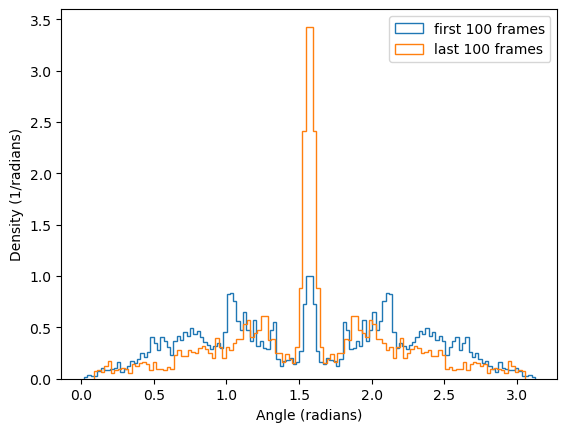

In [15]:
plt.figure()
plt.hist(angle_1to99, bins=int(np.sqrt(len(angle_1to99))), density='True', histtype='step', label='first 100 frames')
plt.hist(angle_100to200, bins=int(np.sqrt(len(angle_100to200))), density='True', histtype='step', label='last 100 frames')
plt.xlabel('Angle (radians)')
plt.ylabel('Density (1/radians)')
plt.legend()
plt.show()